# Thinkful - 3.7.1 - Capstone - Predicting Student Performance

The dataset that I chose to work with is student performance data on standardized English and Math language tests in 1,272 NYC schools in 2016, located here:

https://www.kaggle.com/passnyc/data-science-for-good#2016%20School%20Explorer.csv

The dataset was made available by PASSNYC. From the passnyc.org website PASSNYC is a "not-for-profit, volunteer organization dedicated to broadening educational opportunities for New York City's talented underserved students." As part of their mission, PASSNYC attempts to increase the diversity of students taking the Specialized High School Admissions Test (SHSAT), which is a standardized test that many specialized high schools in the NYC area require for admission. identify underserved and underperforming schools and provide resources to those schools to improve their performance.

In addition to the average student performance on the math and english exams, the dataset includes information such as economic need, student attendance, and how rigorous the instruction is, among others.

The questions that I chose to explore are:
1. What are the strongest predictors of student academic performance at a given school?
2. What are the most effective ways to enhance student academic performance?

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
import time
from sklearn.model_selection import cross_val_score
from sklearn import ensemble

# Display preferences.
#pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(action="ignore",module="scipy",message="^internal gelsd")

# Grab and process the raw data.
df_raw = pd.read_csv('Data/2016 School Explorer_v2.csv', encoding='latin1')

# Data Exploration

First, I explored the data. The raw dataset contains 161 features. There are a few features with significant amount of missing data, and a few features that I suspect may have multicollinearity issues.

In [2]:
df_raw.head()

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),...,Grade 8 Math - All Students Tested,Grade 8 Math 4s - All Students,Grade 8 Math 4s - American Indian or Alaska Native,Grade 8 Math 4s - Black or African American,Grade 8 Math 4s - Hispanic or Latino,Grade 8 Math 4s - Asian or Pacific Islander,Grade 8 Math 4s - White,Grade 8 Math 4s - Multiracial,Grade 8 Math 4s - Limited English Proficient,Grade 8 Math 4s - Economically Disadvantaged
0,NaN,NaN,NaN,P.S. 015 ROBERTO CLEMENTE,3.100000e+11,01M015,1,40.721834,-73.978766,"333 E 4TH ST NEW YORK, NY 10009",...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,NaN,P.S. 019 ASHER LEVY,3.100000e+11,01M019,1,40.729892,-73.984231,"185 1ST AVE NEW YORK, NY 10003",...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,P.S. 020 ANNA SILVER,3.100000e+11,01M020,1,40.721274,-73.986315,"166 ESSEX ST NEW YORK, NY 10002",...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,P.S. 034 FRANKLIN D. ROOSEVELT,3.100000e+11,01M034,1,40.726147,-73.975043,"730 E 12TH ST NEW YORK, NY 10009",...,48,1,0,0,0,0,0,0,0,0
4,NaN,NaN,NaN,THE STAR ACADEMY - P.S.63,3.100000e+11,01M063,1,40.724404,-73.986360,"121 E 3RD ST NEW YORK, NY 10009",...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_raw.shape

(1272, 161)

In [4]:
null_track = df_raw.isnull().sum()
null_track[null_track>0]

Adjusted Grade                            1270
New?                                      1245
Other Location Code in LCGMS              1271
Economic Need Index                         25
School Income Estimate                     396
Student Attendance Rate                     25
Percent of Students Chronically Absent      25
Rigorous Instruction %                      25
Rigorous Instruction Rating                 76
Collaborative Teachers %                    25
Collaborative Teachers Rating               76
Supportive Environment %                    25
Supportive Environment Rating               80
Effective School Leadership %               25
Effective School Leadership Rating          73
Strong Family-Community Ties %              25
Strong Family-Community Ties Rating         73
Trust %                                     25
Trust Rating                                73
Student Achievement Rating                  86
Average ELA Proficiency                     55
Average Math 

In [5]:
df_raw.dtypes

Adjusted Grade                                         object
New?                                                   object
Other Location Code in LCGMS                           object
School Name                                            object
SED Code                                              float64
Location Code                                          object
District                                                int64
Latitude                                              float64
Longitude                                             float64
Address (Full)                                         object
City                                                   object
Zip                                                     int64
Grades                                                 object
Grade Low                                              object
Grade High                                             object
Community School?                                      object
Economic

**Multicollinearity Check**

There are a few sets of features that may be related to one another:
1. 'Average ELA Proficiency' (ELA = English Language) and 'Average Math Proficiency': Determine which variable to use as the outcome variable
2. 'Economic Need Index' and 'School Income Estimate': Determine if they're correlated strongly enough such that 'School Income Estimate' can be dropped, as it's missing 396 values.
3. 'Student Attendance Rate' and 'Percent of Students Chronically Absent': Evaluate for multicollinearity potential.
4. 'District' and Race percentages: Evaluate for multicollinearity potential, as the geographic distribution of races may not be homogenous.
5. Race percentages: Evaluate for multicollinearity potential. Since these metrics are percentages, there is inherent multicollinearity, because as the percentage of a given race increases, another will decrease.
6. 'Economic Need Index' and race percentages: Evaluate for multicollinearity potential.

,Average ELA Proficiency,Average Math Proficiency,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,District
Average ELA Proficiency,1.000000,0.935956,-0.806292,0.674341,-0.350695,0.462710,-0.364160,-0.440421,-0.748990,0.650427,0.038763,-0.520142,0.108616
Average Math Proficiency,0.935956,1.000000,-0.715865,0.585321,-0.229166,0.528597,-0.403549,-0.382057,-0.735648,0.579286,-0.007049,-0.505590,0.115365
Economic Need Index,-0.806292,-0.715865,1.000000,-0.890908,0.421872,-0.359294,0.273100,0.571528,0.775140,-0.771980,-0.184419,0.565757,-0.268786
School Income Estimate,0.674341,0.585321,-0.890908,1.000000,-0.340232,0.247352,-0.281817,-0.490580,-0.685344,0.716063,0.160656,-0.476172,0.217235
Percent ELL,-0.350695,-0.229166,0.421872,-0.340232,1.000000,0.202451,-0.420785,0.540179,0.067981,-0.241909,0.042779,0.038798,-0.037658
Percent Asian,0.462710,0.528597,-0.359294,0.247352,0.202451,1.000000,-0.449714,-0.311739,-0.718471,0.157085,0.182024,-0.403291,0.288328
Percent Black,-0.364160,-0.403549,0.273100,-0.281817,-0.420785,-0.449714,1.000000,-0.432019,0.595885,-0.475889,-0.185014,0.347487,-0.004982
Percent Hispanic,-0.440421,-0.382057,0.571528,-0.490580,0.540179,-0.311739,-0.432019,1.000000,0.466664,-0.368697,-0.030742,0.203367,-0.297392
Percent Black / Hispanic,-0.748990,-0.735648,0.775140,-0.685344,0.067981,-0.718471,0.595885,0.466664,1.000000,-0.795222,-0.208507,0.520729,-0.269409
Percent White,0.650427,0.579286,-0.771980,0.716063,-0.241909,0.157085,-0.475889,-0.368697,-0.795222,1.000000,0.141135,-0.390038,0.140641


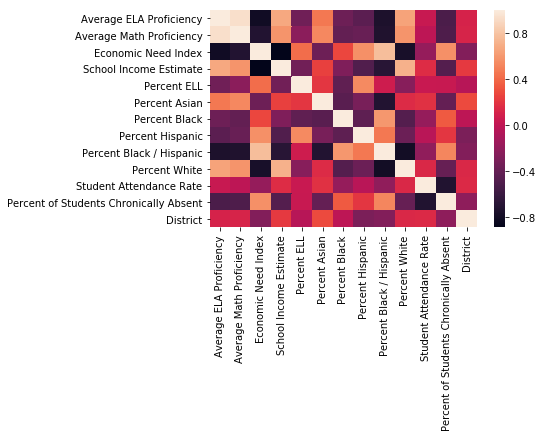

In [6]:
multicoll = df_raw[['Average ELA Proficiency',
                    'Average Math Proficiency',
                    'Economic Need Index',
                    'School Income Estimate',
                    'Percent ELL',
                    'Percent Asian',
                    'Percent Black',
                    'Percent Hispanic',
                    'Percent Black / Hispanic',
                    'Percent White',
                    'Student Attendance Rate',
                    'Percent of Students Chronically Absent',
                   'District']]

sns.heatmap(multicoll.corr())
correlation_matrix = multicoll.corr()
display(correlation_matrix)

From our correlation matrix and correlation heat map, we can see:
1. 'Average ELA Proficiency' and 'Average Math Proficiency': The 'Average ELA Proficiency' variable had slightly stronger relationships with the other features than the 'Average Math Proficiency' and therefore will be the outcome variable.
2. 'Economic Need Index' and 'School Income Estimate': There is a strong negative correlation of -0.9 between the two features, meaning that as the economic need index increases, the school income estimate decreases. This strong correlation shows that 'Economic Need Index' contains most of the information that could be gleaned from 'School Income Estimate' such that 'School Income Estimate' can be dropped, as it's missing 396 values.
3. 'Student Attendance Rate' and 'Percent of Students Chronically Absent': There is a strong negative correlation of -0.72 between the 'Student Attendance Rate' and 'Percent of Students Chronically Absent', meaning that as the student attendance rate increases, the percent of students chronically absent decreases. This will present multicollinearity issues and therefore one variable should be dropped for linear regression models. As the 'Percent of Students Chronically Absent' has a much stronger relationship with both outcome variable, the 'Student Attendance Rate' will be dropped for linear and logistic regression models. 
4. 'District' and Race percentages: There appears to be only weak correlations between 'District' and race percentages and therefore the variable 'District' should not be dropped.
5. Race percentages: The strongest relationship between the race percentages is a -0.79 correlation between 'Percent Black/Hispanic' and 'Percent White', meaning that as the percentage of black/hispanic students increases, the percentage of white students decreases.
6. 'Economic Need Index' and Race Percentages: Two strong relationships exist between economic need and race percentages, which is a 0.78 correlation between economic need and 'Percent Black/Hispanic', meaning that as the percentage of black/hispanic students increases, so does the economic need. The other is a -0.77 correlation between economic need and 'Percent White', meaning that as the percentage of white students increases, the economic need decreases.

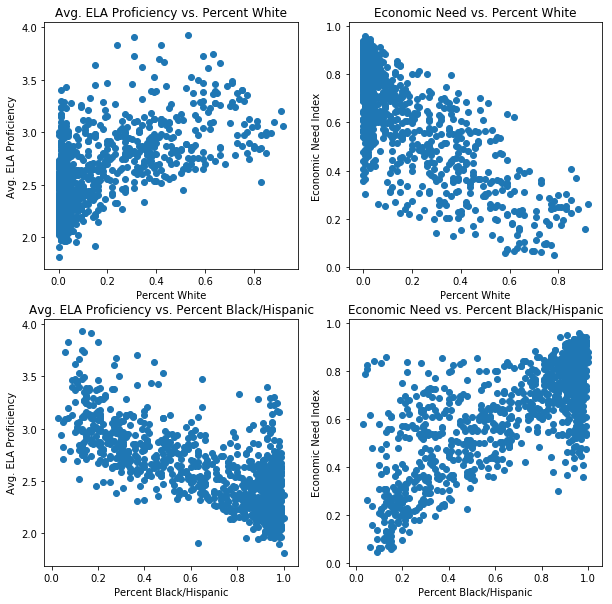

In [7]:
# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.scatter(df_raw['Percent White'], df_raw['Average ELA Proficiency'])
ax2.scatter(df_raw['Percent White'], df_raw['Economic Need Index'])
ax3.scatter(df_raw['Percent Black / Hispanic'], df_raw['Average ELA Proficiency'])
ax4.scatter(df_raw['Percent Black / Hispanic'], df_raw['Economic Need Index'])
               
# Set X-labels
ax1.set_xlabel('Percent White')
ax2.set_xlabel('Percent White')
ax3.set_xlabel('Percent Black/Hispanic')
ax4.set_xlabel('Percent Black/Hispanic')

# Set Y-labels
ax1.set_ylabel('Avg. ELA Proficiency')
ax2.set_ylabel('Economic Need Index')
ax3.set_ylabel('Avg. ELA Proficiency')
ax4.set_ylabel('Economic Need Index')

ax1.set_title('Avg. ELA Proficiency vs. Percent White')
ax2.set_title('Economic Need vs. Percent White')
ax3.set_title('Avg. ELA Proficiency vs. Percent Black/Hispanic')
ax4.set_title('Economic Need vs. Percent Black/Hispanic')
#ax2.set_title('ax2 title')

The plots above show that as the percentage of white students increases, the economic need decreases and the average ELA proficiency increases. Conversely, when the percentage of black/hispanic students increases, the economic need increses and the average ELA proficiency decreases. Beyond these two strong trends, however, the correlations between race percentages and average ELA proficiency for other races was much weaker.

Given the strong correlation between economic need and academic performance, and the weaker correlations between race percentages and academic performance, it is my hypothesis that student academic performance is product of economic need as opposed to race, and that any apparent relationship between race percentage and academic performance is due to a relationship between race distribution and economic distribution.

The correlation matrix confirmed this relationship, with a -0.81 correlation between economic need and ELA proficiency. See the graph below.

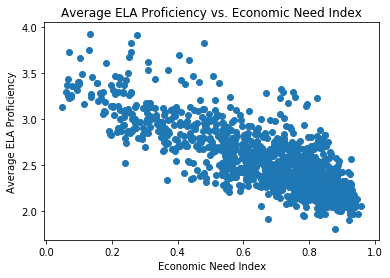

In [8]:
# Plot the solution.
plt.scatter(df_raw['Economic Need Index'], df_raw['Average ELA Proficiency'])
plt.xlabel('Economic Need Index')
plt.ylabel('Average ELA Proficiency')
plt.title('Average ELA Proficiency vs. Economic Need Index')
plt.show()

Possible reasons for the strong relationship between economic need and academic performance may be related to the fact that schools with a greater economic need:
1. Don't have the funding for specialized teaching programs, such as special education programs or English as a second language (ESL) programs.
2. Don't have the funding for arts or sports programs, which can teach critical thinking skills.
3. Don't have the funding to hire adequate numbers of teachers or build enough classrooms, meaning that there are high student-teacher ratios, such that the teachers cannot give the students the necessary feedback to enhance their learning.
4. Are located in poorer areas (as property taxes often fund local schools), meaning that the students' ability to learn may be hindered by outside influences such as hunger or sleep deprivation.

What this data cannot explain is why this racial and economic distribution exists, however, that is beyond the scope of this analysis. Given the arguments above, I will be excluding race information from all of my models.

# Data Cleaning

In [9]:
# Drop all features with all null values
df1 = df_raw.drop(['Adjusted Grade','New?','Other Location Code in LCGMS'],axis=1)

# Drop all features with distinct values for each entry, as unique won't provide any new information
df1 = df1.drop(['School Name','Zip','SED Code','Location Code','Address (Full)','Grade Low',
                         'Grade High','Grades','Latitude','Longitude'],axis=1)

df1.shape

(1272, 148)

In [10]:
# Drop 'School Income Estimate' due to the significant missing data 
df1 = df1.drop(['School Income Estimate'],axis=1)

df1.shape

(1272, 147)

In [11]:
# Drop all features that count the number of students who got 4's on either the ELA or Math exams,
# as these are essentially just different forms of the outcome variable.
df1.drop(list(df1.filter(regex = 'ELA 4s')), axis = 1, inplace = True)
df1.drop(list(df1.filter(regex = 'Math 4s')), axis = 1, inplace = True)

df1.shape

(1272, 39)

In [12]:
# Drop all NA values
df1 = df1.dropna()

df1.shape

(1167, 39)

In [13]:
df1.dtypes

District                                    int64
City                                       object
Community School?                          object
Economic Need Index                       float64
Percent ELL                               float64
Percent Asian                             float64
Percent Black                             float64
Percent Hispanic                          float64
Percent Black / Hispanic                  float64
Percent White                             float64
Student Attendance Rate                   float64
Percent of Students Chronically Absent    float64
Rigorous Instruction %                    float64
Rigorous Instruction Rating                object
Collaborative Teachers %                  float64
Collaborative Teachers Rating              object
Supportive Environment %                  float64
Supportive Environment Rating              object
Effective School Leadership %             float64
Effective School Leadership Rating         object


**Convert categorical variables into dummy variables**

In [14]:
# Dataframe which only contains categorical variables, which will be converted to dummies.
df = pd.get_dummies(df1, columns=['City','Community School?','Rigorous Instruction Rating',
                                         'Collaborative Teachers Rating','Supportive Environment Rating',
                                         'Effective School Leadership Rating','Strong Family-Community Ties Rating',
                                         'Trust Rating','Student Achievement Rating'],drop_first = True)
df.head()

,District,Economic Need Index,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,...,Effective School Leadership Rating_Not Meeting Target,Strong Family-Community Ties Rating_Exceeding Target,Strong Family-Community Ties Rating_Meeting Target,Strong Family-Community Ties Rating_Not Meeting Target,Trust Rating_Exceeding Target,Trust Rating_Meeting Target,Trust Rating_Not Meeting Target,Student Achievement Rating_Exceeding Target,Student Achievement Rating_Meeting Target,Student Achievement Rating_Not Meeting Target
0,1,0.919,0.09,0.05,0.32,0.60,0.92,0.01,0.94,0.18,...,0,0,1,0,1,0,0,0,0,0
2,1,0.744,0.15,0.35,0.08,0.49,0.57,0.04,0.94,0.20,...,1,0,0,0,0,0,1,0,0,0
3,1,0.860,0.07,0.05,0.29,0.63,0.92,0.04,0.92,0.28,...,0,0,1,0,0,1,0,1,0,0
4,1,0.730,0.03,0.04,0.20,0.65,0.84,0.10,0.93,0.23,...,0,0,1,0,0,1,0,0,1,0
5,1,0.858,0.06,0.07,0.19,0.66,0.84,0.07,0.92,0.33,...,0,0,1,0,1,0,0,0,1,0


In [15]:
Y1 = df['Average ELA Proficiency']
Y2 = df['Average Math Proficiency']
X = df.drop(['Average ELA Proficiency','Average Math Proficiency'],axis=1)

print(df.shape)
df.head()

(1167, 96)


,District,Economic Need Index,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,...,Effective School Leadership Rating_Not Meeting Target,Strong Family-Community Ties Rating_Exceeding Target,Strong Family-Community Ties Rating_Meeting Target,Strong Family-Community Ties Rating_Not Meeting Target,Trust Rating_Exceeding Target,Trust Rating_Meeting Target,Trust Rating_Not Meeting Target,Student Achievement Rating_Exceeding Target,Student Achievement Rating_Meeting Target,Student Achievement Rating_Not Meeting Target
0,1,0.919,0.09,0.05,0.32,0.60,0.92,0.01,0.94,0.18,...,0,0,1,0,1,0,0,0,0,0
2,1,0.744,0.15,0.35,0.08,0.49,0.57,0.04,0.94,0.20,...,1,0,0,0,0,0,1,0,0,0
3,1,0.860,0.07,0.05,0.29,0.63,0.92,0.04,0.92,0.28,...,0,0,1,0,0,1,0,1,0,0
4,1,0.730,0.03,0.04,0.20,0.65,0.84,0.10,0.93,0.23,...,0,0,1,0,0,1,0,0,1,0
5,1,0.858,0.06,0.07,0.19,0.66,0.84,0.07,0.92,0.33,...,0,0,1,0,1,0,0,0,1,0


# Weighted KNN Regression

As was mentioned during the multicollinearity analysis, I will be dropping the 'Student Attendance Rate' and all data related to race percentages for the regression models.

In [16]:
# Drop 'Student Attendance Rate' due to multicollinearity with
# 'Percent Students Chronically Absent'
X2 = X.drop(['Student Attendance Rate'],axis=1)

# Drop all race percentages except for 'Percent Black/Hispanic' due to multicollinearity
# 'Percent Black/Hispanic' had the strongest relationships with other independent variables
X2 = X2.drop(['Percent Asian','Percent Black','Percent White','Percent Hispanic','Percent Black / Hispanic'],axis=1)

X2.shape

(1167, 88)

R-squared:  0.453056144517
[-0.54415971 -0.48521306 -2.37068112 -0.28317514  0.18947617  0.02446378
 -0.19543891 -0.05913379 -0.10705576 -0.28612843]
Weighted Accuracy: -0.41 (+/- 1.37)


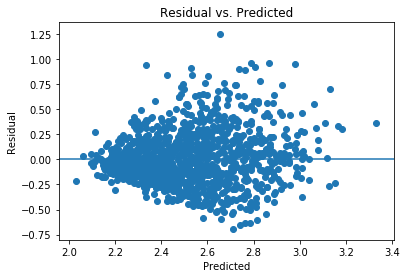

In [17]:
from sklearn import neighbors
# Run the same model, this time with weights.
#knn_w = neighbors.KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_w = neighbors.KNeighborsRegressor(n_neighbors=4)
knn_w.fit(X2,Y1)

#Inspect results
print("R-squared: ",knn_w.score(X2,Y1))
score_knn = cross_val_score(knn_w, X2, Y1, cv=10)
print(score_knn)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_knn.mean(), score_knn.std() * 2))

# Extract predicted values.
predict_knn = knn_w.predict(X2)
resid_knn = Y1 - predict_knn

df['KNN Predict'] = pd.Series(predict_knn, index=df.index)
df['KNN Resid'] = pd.Series(resid_knn, index=df.index)
plt.scatter(predict_knn, resid_knn)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Linear Regression


R-squared:
0.844930238852
[ 0.88067518  0.75510208  0.66834844  0.67957442  0.7860801   0.71281589
  0.81561851  0.56481806  0.77818158 -0.49983298]
Weighted Accuracy: 0.61 (+/- 0.76)


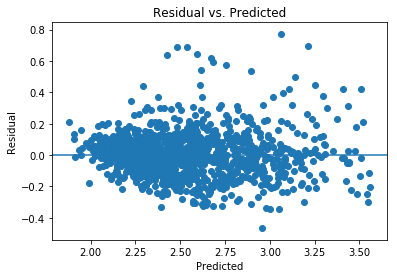

In [18]:
from sklearn import linear_model

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X2, Y1)

# Inspect the results.
print('\nR-squared:')
print(regr.score(X2, Y1))

# Extract predicted values.
predicted = regr.predict(X2).ravel()
actual = Y1

# Calculate the error, also called the residual.
residual = actual - predicted

df['Predicted'] = pd.Series(predicted, index=df.index)
df['Residual'] = pd.Series(residual, index=df.index)

#Inspect results
score_regr = cross_val_score(regr, X2, Y1, cv=10)
print(score_regr)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_regr.mean(), score_regr.std() * 2))

# Extract predicted values.
predict_regr = regr.predict(X2)
resid_regr = Y1 - predict_regr

df['Regr Predict'] = pd.Series(predict_regr, index=df.index)
df['Regr Resid'] = pd.Series(resid_regr, index=df.index)
plt.scatter(predict_regr, resid_regr)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Support Vector Machines


R-squared:
0.923455294393
[-0.33562303 -0.98031351 -1.98683754 -0.54983917 -0.05770948 -0.04028173
 -0.18268174 -0.0110649  -0.06302168  0.045971  ]
Weighted Accuracy: -0.42 (+/- 1.21)


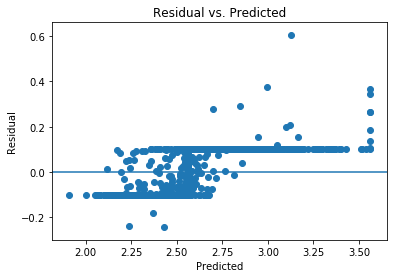

In [19]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X,Y1)

#Inspect results
print('\nR-squared:')
print(svr.score(X, Y1))
score_svr = cross_val_score(svr, X, Y1, cv=10)
print(score_svr)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_svr.mean(), score_svr.std() * 2))

# Extract predicted values.
predict_svr = svr.predict(X)
resid_svr = Y1 - predict_svr

df['SVR Predict'] = pd.Series(predict_svr, index=df.index)
df['SVR Resid'] = pd.Series(resid_svr, index=df.index)
plt.scatter(predict_svr, resid_svr)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Gradient Boost Regressor

To build the gradient boost regressor model, I first wanted to explore which parameters produced the best model.

In [20]:
r_sqr_a = []
mean_cv_a = []
iteration = []
est_n = []
max_depth = []
loss = []
i = 1

start = time.time()

for n in range(1000, 5000, 1000):
    for m in range(1, 5):
        params = {'n_estimators': n,
                  'max_depth': m,
                  'loss': 'ls'}

        clf = ensemble.GradientBoostingRegressor(**params)
        clf.fit(X,Y1)

        r_sqr = clf.score(X, Y1)
        score = cross_val_score(clf, X, Y1, cv=5)
        mean_cv = score.mean()

        r_sqr_a.append(r_sqr)
        mean_cv_a.append(mean_cv)
        est_n.append(n)
        max_depth.append(m)
        loss.append('ls')
        iteration.append(i)
        i += 1

stop = time.time()
a = stop - start
print("Run time = ",a)

Run time =  283.95989203453064


In [21]:
df_CLF = pd.DataFrame(r_sqr_a,columns=['R-squared'])
df_CLF['Mean CV'] = pd.Series(mean_cv_a, index=df_CLF.index)
df_CLF['Estimators'] = pd.Series(est_n, index=df_CLF.index)
df_CLF['Max Depth'] = pd.Series(max_depth, index=df_CLF.index)
df_CLF['Loss Type'] = pd.Series(loss, index=df_CLF.index)
df_CLF['Iteration'] = pd.Series(iteration, index=df_CLF.index)

df_CLF.head()

,R-squared,Mean CV,Estimators,Max Depth,Loss Type,Iteration
0,0.912704,0.773448,1000,1,ls,1
1,0.973111,0.768437,1000,2,ls,2
2,0.995996,0.760210,1000,3,ls,3
3,0.999811,0.748130,1000,4,ls,4
4,0.923387,0.772896,2000,1,ls,5


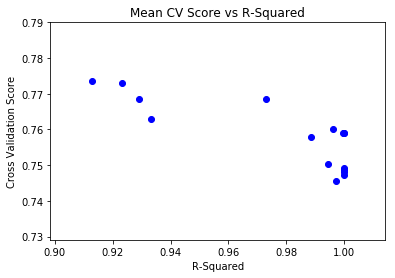

In [22]:
# Look at our data.
plt.scatter(r_sqr_a,mean_cv_a,color='blue')
plt.title('Mean CV Score vs R-Squared')
plt.xlabel('R-Squared')
plt.ylabel('Cross Validation Score')
plt.show()

Given the graph above, it appears that there is significant overfitting in the model. The model with the least overfitting is the model with the smallest difference between the R-squared value and the mean CV.

In [23]:
diff = df_CLF['R-squared']-df_CLF['Mean CV']
df_CLF['Difference'] = pd.Series(diff, index=df_CLF.index)

In [24]:
df_CLF.loc[df_CLF['Difference'].idxmin()]

R-squared     0.912704
Mean CV       0.773448
Estimators        1000
Max Depth            1
Loss Type           ls
Iteration            1
Difference    0.139256
Name: 0, dtype: object

Plugging those parameters into the model, the outcome is:


R-squared:
0.912704009347
[ 0.92190932  0.7808566   0.81673908  0.84085876  0.50683678]
Weighted Accuracy: 0.77 (+/- 0.28)


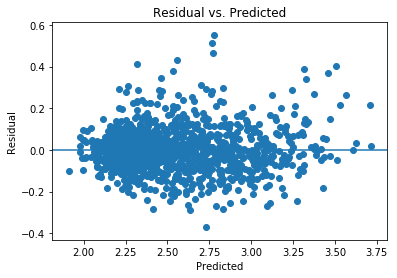

In [25]:
params = {'n_estimators': 1000,'max_depth': 1,'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X,Y1)

#Inspect results
print('\nR-squared:')
print(clf.score(X, Y1))
score_w = cross_val_score(clf, X, Y1, cv=5)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Extract predicted values.
predict_clf = clf.predict(X)
resid_clf = Y1 - predict_clf

df['CLF Predict'] = pd.Series(predict_clf, index=df.index)
df['CLF Resid'] = pd.Series(resid_clf, index=df.index)
plt.scatter(predict_clf, resid_clf)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

I later discovered a simpler method of searching for the optimal parameters, which is the GridSearchCV function:

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

params = {'loss':['ls','lad','huber','quantile'],
              'max_depth':[1,2,3,4,5],
              'max_features':['log2','sqrt','auto'],
              'n_estimators':[50,100,1000,2000,3000,4000,5000]}

gbr = ensemble.GradientBoostingRegressor(params)
clf = GridSearchCV(gbr, params, cv=5, n_jobs=-1,verbose=1)
clf.fit(X,Y1)

print(clf.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 359 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 959 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1409 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 1959 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed: 18.5min finished


{'loss': 'ls', 'max_depth': 2, 'n_estimators': 100, 'max_features': 'auto'}



R-squared:
0.908498523138
[ 0.92930226  0.7990972   0.80933369  0.85631008  0.55056207]
Weighted Accuracy: 0.79 (+/- 0.26)


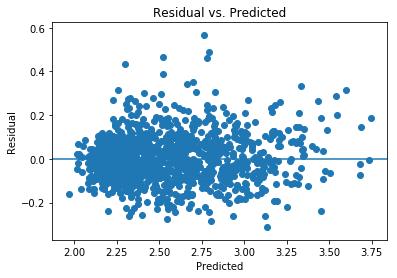

In [27]:
params = {'n_estimators': 100,'max_depth': 2,'loss': 'ls','max_features':'auto'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X,Y1)

#Inspect results
print('\nR-squared:')
print(clf.score(X, Y1))
score_w = cross_val_score(clf, X, Y1, cv=5)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Extract predicted values.
predict_clf = clf.predict(X)
resid_clf = Y1 - predict_clf

df['CLF Predict'] = pd.Series(predict_clf, index=df.index)
df['CLF Resid'] = pd.Series(resid_clf, index=df.index)
plt.scatter(predict_clf, resid_clf)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [28]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(20)
print(feat_importances)

Percent ELL                                     0.155514
Percent of Students Chronically Absent          0.110593
Economic Need Index                             0.089256
Percent Black / Hispanic                        0.080754
District                                        0.069125
Student Attendance Rate                         0.062351
Student Achievement Rating_Exceeding Target     0.046204
Percent Asian                                   0.043885
Percent Hispanic                                0.034682
Student Achievement Rating_Meeting Target       0.031458
Rigorous Instruction %                          0.030327
Supportive Environment %                        0.029216
Effective School Leadership %                   0.021917
Rigorous Instruction Rating_Exceeding Target    0.018514
Percent Black                                   0.018224
Community School?_Yes                           0.018187
Grade 4 ELA - All Students Tested               0.013811
City_STATEN ISLAND             

After outputting the most important features, it is apparent that proficiency with the English language, attendance and economic need are the key variables in academic performance. However, it appears that many of the race percentage features are shown as key features, which I suspect is misallocated from the economic index. I evaluated the model after removing these features, as well as 'Student Attendance Rate', below.


R-squared:
0.892133831646
[ 0.89439271  0.77317257  0.76808518  0.82430339  0.48054131]
Weighted Accuracy: 0.75 (+/- 0.28)


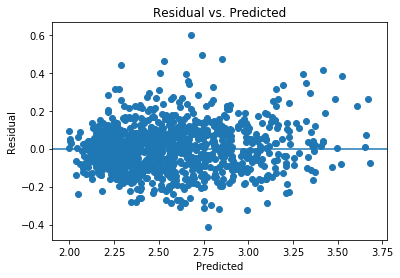

In [29]:
# Drop 'Student Attendance Rate' due to multicollinearity with
# 'Percent Students Chronically Absent'
X1 = X.drop(['Student Attendance Rate'],axis=1)

# Drop all race percentages except for 'Percent Black/Hispanic' due to multicollinearity
# 'Percent Black/Hispanic' had the strongest relationships with other independent variables
X1 = X1.drop(['Percent Asian','Percent Black','Percent White','Percent Hispanic','Percent Black / Hispanic'],axis=1)

params = {'n_estimators': 100,'max_depth': 2,'loss': 'ls','max_features':'auto'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X1,Y1)

#Inspect results
print('\nR-squared:')
print(clf.score(X1, Y1))
score_clf = cross_val_score(clf, X1, Y1, cv=5)
print(score_clf)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_clf.mean(), score_clf.std() * 2))

# Extract predicted values.
predict_clf = clf.predict(X1)
resid_clf = Y1 - predict_clf

df['CLF Predict'] = pd.Series(predict_clf, index=df.index)
df['CLF Resid'] = pd.Series(resid_clf, index=df.index)
plt.scatter(predict_clf, resid_clf)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

These results are interesting because despite dropping these 6 features, the model performance hardly changed at all, which indicates that they may not be key features, given their collinearity with other relevant features.

In [30]:
feat_importances = pd.Series(clf.feature_importances_, index=X1.columns)
feat_importances = feat_importances.nlargest(20)
print(feat_importances)

Economic Need Index                             0.192558
Percent of Students Chronically Absent          0.157724
Percent ELL                                     0.111466
Supportive Environment %                        0.061558
District                                        0.056255
Student Achievement Rating_Exceeding Target     0.051419
Strong Family-Community Ties %                  0.037802
Student Achievement Rating_Meeting Target       0.033336
Rigorous Instruction %                          0.033144
City_ROSEDALE                                   0.024485
Grade 3 ELA - All Students Tested               0.021140
Effective School Leadership %                   0.019734
Community School?_Yes                           0.018911
Grade 3 Math - All Students tested              0.018474
Grade 8 Math - All Students Tested              0.018337
Rigorous Instruction Rating_Exceeding Target    0.017976
Grade 7 ELA - All Students Tested               0.017035
City_SPRINGFIELD GARDENS       

Outputting the feature importance also shows that the 'Economic Need Index' increased in importance, potentially as a result of removing the race features, which the model had previously attributed value that could have been attributed to the economic need index. This also shows us that the top 3 features can explain about 46% of the variance in the model.

Lastly, I explored a model that explains only the features that can be influenced by the leaders of this non-profit.

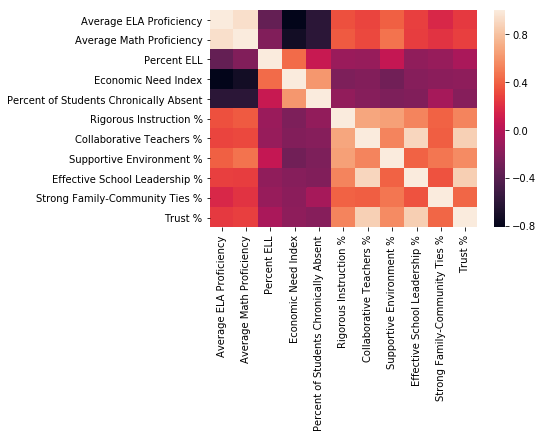

In [31]:
mtx = df[['Average ELA Proficiency',
      'Average Math Proficiency',
      'Percent ELL',
      'Economic Need Index',
      'Percent of Students Chronically Absent',
      'Rigorous Instruction %',
      'Collaborative Teachers %',
      'Supportive Environment %',
      'Effective School Leadership %',
      'Strong Family-Community Ties %',
      'Trust %']]

sns.heatmap(mtx.corr())


R-squared:
0.838198321348
[ 0.83099629  0.67643557  0.73568361  0.76889555  0.23742879]
Weighted Accuracy: 0.65 (+/- 0.42)


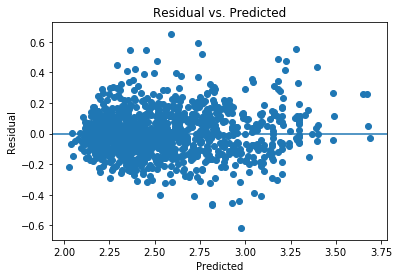

In [32]:
X1 = df[['Percent ELL',
      'Economic Need Index',
      'Percent of Students Chronically Absent',
      'Rigorous Instruction %',
      'Collaborative Teachers %',
      'Supportive Environment %',
      'Effective School Leadership %',
      'Strong Family-Community Ties %',
      'Trust %']]

params = {'n_estimators': 100,'max_depth': 2,'loss': 'ls','max_features':'auto'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X1,Y1)

#Inspect results
print('\nR-squared:')
print(clf.score(X1, Y1))
score_w = cross_val_score(clf, X1, Y1, cv=5)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Extract predicted values.
predict_clf = clf.predict(X1)
resid_clf = Y1 - predict_clf

df['CLF Predict'] = pd.Series(predict_clf, index=df.index)
df['CLF Resid'] = pd.Series(resid_clf, index=df.index)
plt.scatter(predict_clf, resid_clf)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [33]:
feat_importances = pd.Series(clf.feature_importances_, index=X1.columns)
feat_importances = feat_importances.nlargest(9)
print(feat_importances)

Percent of Students Chronically Absent    0.310449
Economic Need Index                       0.206550
Percent ELL                               0.134134
Strong Family-Community Ties %            0.101294
Supportive Environment %                  0.098653
Rigorous Instruction %                    0.077624
Trust %                                   0.040615
Effective School Leadership %             0.030681
Collaborative Teachers %                  0.000000
dtype: float64


Potential ways to improve academic performance include developing programs to improve English language understanding and community programs.

# Conclusions

In conclusion, I evaluated four models:

In [35]:
summary = np.array([['Support Vector Machines',"%0.2f" % svr.score(X, Y1),
                      "%0.2f (+/- %0.2f)" % (score_svr.mean(), score_svr.std() * 2)],
                  ['Weighted KNN Regression',"%0.2f" % knn_w.score(X2, Y1),
                      "%0.2f (+/- %0.2f)" % (score_knn.mean(), score_knn.std() * 2)],
                  ['Linear Regression',"%0.2f" % regr.score(X2, Y1),
                      "%0.2f (+/- %0.2f)" % (score_regr.mean(), score_regr.std() * 2)],
                  ['Gradient Boosting Regression',"%0.2f" % clf.score(X1, Y1),
                      "%0.2f (+/- %0.2f)" % (score_clf.mean(), score_clf.std() * 2)]])

df_summary = pd.DataFrame(summary)
df_summary.columns = ['Model','R-squared','Mean CV']

df_summary.head()

,Model,R-squared,Mean CV
0,Support Vector Machines,0.92,-0.42 (+/- 1.21)
1,Weighted KNN Regression,0.45,-0.41 (+/- 1.37)
2,Linear Regression,0.84,0.61 (+/- 0.76)
3,Gradient Boosting Regression,0.84,0.75 (+/- 0.28)


In general, my models were explanatory in nature. This was by design because not only did I want to develop a good model, but I also wanted to understand the impact the features had on the outcome variable.

The gradient boosting model had the best performance, however, I spent the most time tuning this model, both by varying the parameters and by modeling different subsets of data. The reason that I prefer the gradient boosting regression is because of its robustness and the ability to evaluate feature importances. 

Potential improvements that could be made to the models include:
1. Developing a new feature which extracts the distance from the epicenter of NYC from the latitude and longitude to determine the relationship between economic need index, academic performance, and geographic distribution.
2. Using GridSearchCV on other models to optimize which parameters are used.